<a href="https://colab.research.google.com/github/MrPotatoHead-Dev/BestCar/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import random

Retrieve Daily stockprice data from yfinance and plot the results 

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Nasdaq'}, xlabel='Time', ylabel='Price'>

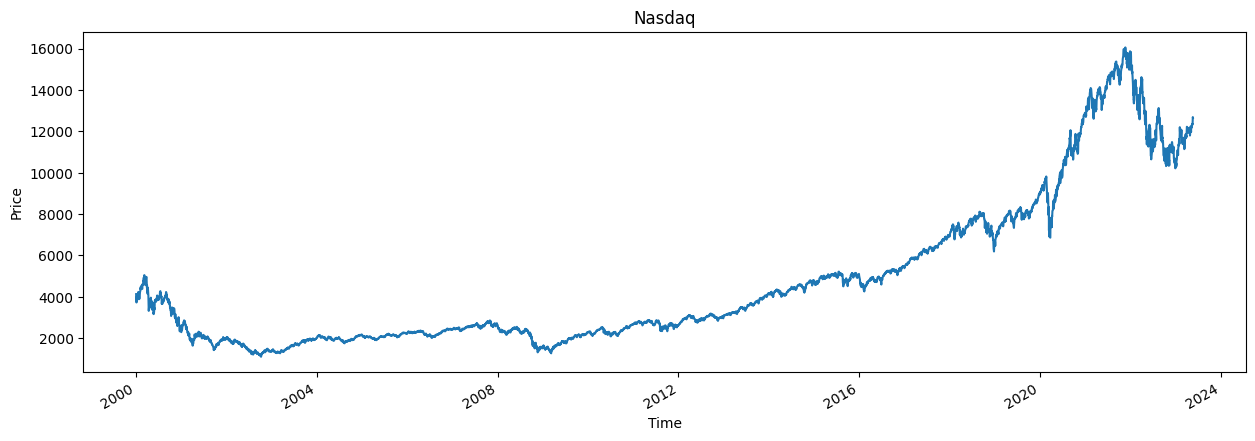

In [13]:
start_date = "2000-01-01"
df = yf.download("^IXIC", start_date)

df['Close'].plot(figsize=(15,5), xlabel='Time', ylabel='Price', title='Nasdaq')

Create a features function that adds certain features that the model will use to find trends

In [3]:
def features(df):
    df["day"] = df.index.day
    df["DoW"] = df.index.day_of_week
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    df["mid_hl"] = df.High + df.Low / 2
    df["mid_oc"] = df.Open + df.Close / 2

    # Moving averages
    df["MA"] = df["Close"].rolling(100).mean()
    horizions = [2,5, 20, 60, 100, 250]
    new_predictors= []
    for i in horizions:
      rolling_avgs= df.rolling(i).mean()
      ratio_name = f'rolling_ratio_{i}'
      df[ratio_name] = df['Close'] / rolling_avgs['Close']
      trend_name = f'trend_{i}'
      df[trend_name] = df.shift(1).rolling(i).sum()["Close"]
      new_predictors += [ratio_name, trend_name]
    # more dataset cleaning
    df = df[df["DoW"] != 6]
    df = df[df["DoW"] != 7]
    df = df[df.High != df.Low]
    df["tomorrow"] = df["Close"].shift(-1)
    
    df = df.dropna()
    # return a 1 for bullish and a 0 for bearish
    df["target"] = df.apply(lambda row: 1 if row.Open > row.Close else 0, axis=1)
    # drop excess data
    return df.copy(), new_predictors

Run the function 

In [4]:
df, new_predictors = features(df)
df.head(20)

Random Forest classifier is well-suited for predicting stock trends due to its robustness to noise, ability to capture non-linear relationships, feature importance analysis, handling of high-dimensional data, ensemble approach, OOB error estimation, and ability to mitigate overfitting. These characteristics make it a popular choice for stock trend prediction tasks.

In [5]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=50, random_state=1)

Single out the columns that will be used in the model

In [6]:
predictors = [

    "day",
    "DoW",
    "month",
    "quarter",
    "year",
    "MA",
    "mid_hl",
    "mid_oc",'rolling_ratio_2',
    'trend_2',
    'rolling_ratio_5',
    'trend_5',
    'rolling_ratio_20',
    'trend_20',
    'rolling_ratio_60',
    'trend_60',
    'rolling_ratio_100',
    'trend_100',
    'rolling_ratio_250',
    'trend_250'
]

The **prediction** function trains a model on training data, predicts target variable for test data, and applies a threshold to classify predictions. The **Backtesting** function conducts backtesting by splitting data into training and test sets at specified intervals.

In [11]:
'''' There are roughly 250 trading days in a year'''

start = 250 
step = 50


def prediction(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds>= 0.6] =1
    preds[preds<0.6] = 0

    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined


def backtest(data, model, predictors, start=start, step=step):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i : (i + step)].copy()
        predictions = prediction(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [12]:
predictions = backtest(df, model, predictors)

In [9]:
predictions['predictions'].value_counts()

0.0    2028
1.0    1104
Name: predictions, dtype: int64

In [10]:
score = precision_score(predictions['target'], predictions['predictions'])

print(f'Nas daily bias probability accuracy: {score:0.4f}')

Nas daily bias probability accuracy: 0.8216
